In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import ast
from scipy.stats import probplot
import statsmodels.api as stats
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker

### Exploratory Question: How do movie ratings (vote average) relate to box-office performance? #4

#### The R-squared is in line with what is seen in these plots in that there is still a significant amount of variability that hasn't been explained with just Vote Average and Revenue. We have a low r-squared value as it is looking at how much variability in Vote Average vs Revenue is explained by the model. 

In [4]:
# Read the csv file in
movies_2015_2024 = pd.read_csv('../data/movies_2015_2024.csv')

# Calculate the Profit column and add it to the df
movies_2015_2024['Profit'] = (movies_2015_2024["Revenue"] - movies_2015_2024["Budget"])

# Inspect the df
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,365000000,1405403694,99861,1040403694
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,150000000,378858340,76341,228858340


In [5]:
movies_2015_2024.nlargest(5, "Profit")

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
401,Avengers: Endgame,2019,"['Adventure', 'Science Fiction', 'Action']",8.237,26930,356000000,2799439100,299534,2443439100
700,Avatar: The Way of Water,2022,"['Action', 'Adventure', 'Science Fiction']",7.611,13044,350000000,2330224914,76600,1980224914
6,Star Wars: The Force Awakens,2015,"['Adventure', 'Action', 'Science Fiction']",7.254,20076,245000000,2068223624,140607,1823223624
300,Avengers: Infinity War,2018,"['Adventure', 'Action', 'Science Fiction']",8.235,31141,300000000,2052415039,299536,1752415039
600,Spider-Man: No Way Home,2021,"['Action', 'Adventure', 'Science Fiction']",7.937,21275,200000000,1921847111,634649,1721847111


In [6]:
# Converting financial data to 2024 dollars
# Store CPI values
cpi_data = pd.read_csv('../data/CPI_data.csv').set_index('Year')
budget_2024 = []
for year,budget in zip(movies_2015_2024['Year'], movies_2015_2024['Budget']):
    budget_adjusted = budget*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    budget_2024.append(budget_adjusted)
# Reassign adjusted budget numbers to the Budget column
movies_2015_2024['Budget'] = budget_2024
revenue_2024 = []
for year,revenue in zip(movies_2015_2024['Year'], movies_2015_2024['Revenue']):
    revenue_adjusted = revenue*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    revenue_2024.append(revenue_adjusted)
# Reassign adjusted budget numbers to the Revenue column
movies_2015_2024['Revenue'] = revenue_2024
# Dropping zero values from budget and revenue
movies_2015_2024 = movies_2015_2024[~((movies_2015_2024['Revenue'].round() == 0.0) | (movies_2015_2024['Budget'].round() == 0.0))]
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,1.985231e+08,5.014142e+08,76341,228858340


In [7]:
movies_2015_2024.nlargest(1, 'Profit')["Title"]

401    Avengers: Endgame
Name: Title, dtype: object

In [8]:
# Convert the Budget and Revenue columns from scientific notation to integers
movies_2015_2024['Budget'] = movies_2015_2024['Budget'].astype('int64') 
movies_2015_2024['Revenue'] = movies_2015_2024['Revenue'].astype('int64')
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,483072880,1860034003,99861,1040403694
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,198523101,501414218,76341,228858340


In [9]:
# Prepare the Genre column to be exploded
movies_2015_2024['Genre'] = movies_2015_2024['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

# Explode the Genre column of the df and don't affect the index however
movies_exploded = movies_2015_2024.explode('Genre', ignore_index = False)
movies_exploded.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,Action,7.271,23855,483072880,1860034003,99861,1040403694
0,Avengers: Age of Ultron,2015,Adventure,7.271,23855,483072880,1860034003,99861,1040403694


In [10]:
# Create a log of Revenue column and populate it with the logs of the Revenue column's values
movies_exploded['log_profit'] = np.log(movies_exploded['Profit'])
movies_exploded.head(2)

C:\Users\cat\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit,log_profit
0,Avengers: Age of Ultron,2015,Action,7.271,23855,483072880,1860034003,99861,1040403694,20.762875
0,Avengers: Age of Ultron,2015,Adventure,7.271,23855,483072880,1860034003,99861,1040403694,20.762875


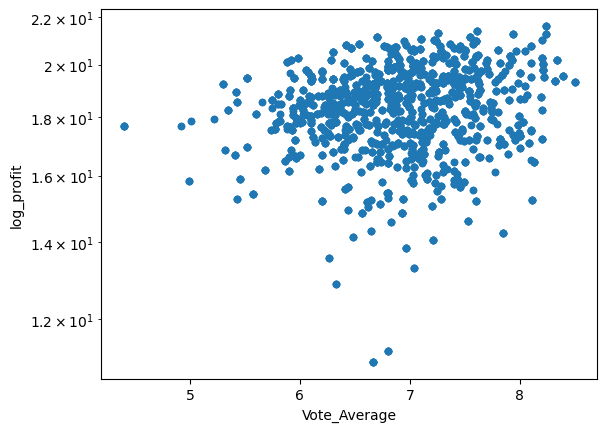

In [11]:
# Inspect the relationship between Vote_Average and Revenue
ax = movies_exploded.plot(
    kind = 'scatter',
    x = 'Vote_Average',
    y = 'log_profit',
    logy=True
)

movies_exploded.plot(
    ax=ax,
    kind = 'scatter',
    x = 'Vote_Average',
    y = 'log_profit'
);

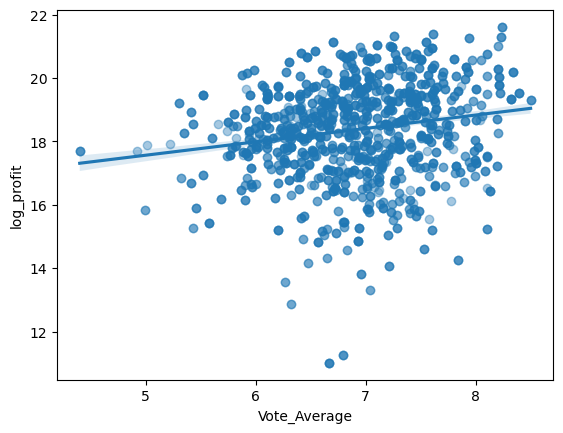

In [12]:
sns.regplot(
    data=movies_exploded,
    x='Vote_Average',
    y='log_profit',
    scatter_kws={'alpha': 0.4}
);

In [13]:
# We assume the average of our target variable, vote avg, is a linear function of the predictor variable, revenue 
lm_profit_va = smf.ols('Profit ~ Vote_Average', data = movies_2015_2024).fit()
lm_profit_va.params

Intercept      -5.374853e+08
Vote_Average    1.024765e+08
dtype: float64

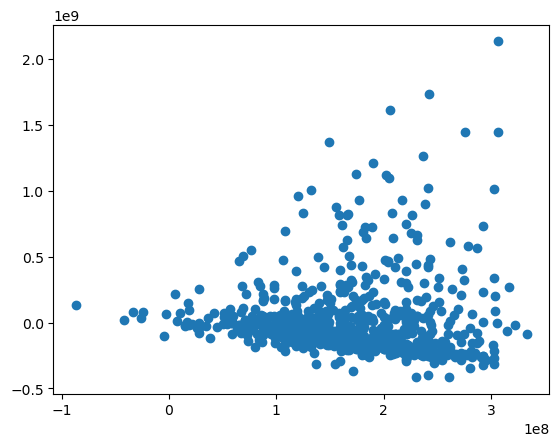

In [14]:
plt.scatter(x = lm_profit_va.fittedvalues, y = lm_profit_va.resid);

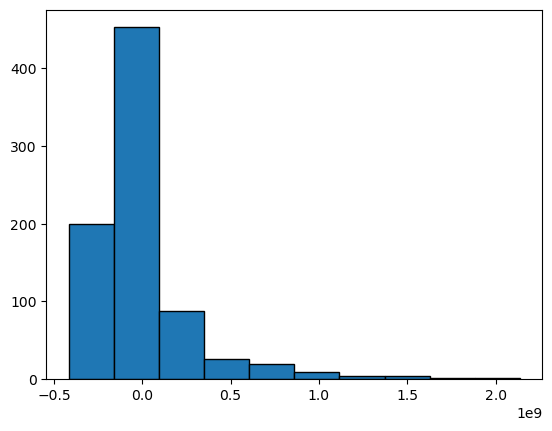

In [15]:
plt.hist(lm_profit_va.resid, edgecolor = 'black');

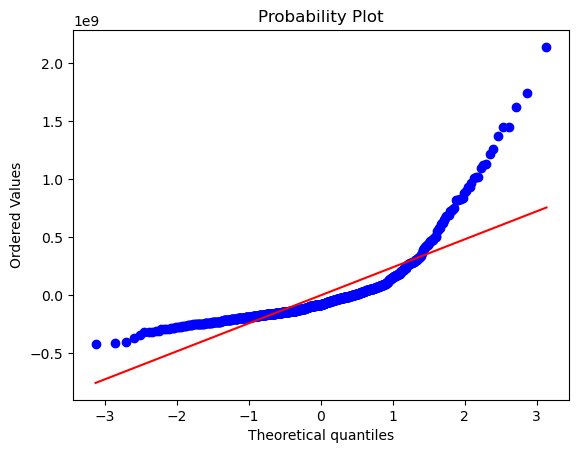

In [16]:
probplot(lm_profit_va.resid, plot = plt);

In [17]:
stats.stats.diagnostic.kstest_normal(lm_profit_va.resid)

(0.18938703565580972, 0.0009999999999998899)

In [18]:
lm_profit_va.conf_int(alpha=0.05)

,0,1
Intercept,-7.486988e+08,-3.262718e+08
Vote_Average,7.191960e+07,1.330335e+08


In [19]:
lm_profit_va.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     43.33
Date:                Tue, 25 Nov 2025   Prob (F-statistic):           8.33e-11
Time:                        21:20:12   Log-Likelihood:                -16806.
No. Observations:                 805   AIC:                         3.362e+04
Df Residuals:                     803   BIC:                         3.363e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -5.375e+08   1.08e+08     -4.995      0.000   -7.49e+08   -3.26e+08
Vote_Average  1.025e+08   1.56e+07      6.583      0.000    7.19e+07    1.33e+08
==============================================================================
Omnibus:                      521.251   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5423.169
Skew:                           2.864   Prob(JB):                         0.00
Kurtosis:                      14.352   Cond. No.                         76.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
x_pred = pd.DataFrame({'Vote_Average': np.linspace(start = movies_2015_2024['Vote_Average'].min(),
                                    stop = movies_2015_2024['Vote_Average'].max(), num = 250)})

lm_profit_va.get_prediction(x_pred).summary_frame().head(2)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-8.658852e+07,3.990786e+07,-1.649246e+08,-8.252478e+06,-6.469511e+08,4.737741e+08
1,-8.490115e+07,3.965970e+07,-1.627501e+08,-7.052228e+06,-6.451959e+08,4.753936e+08


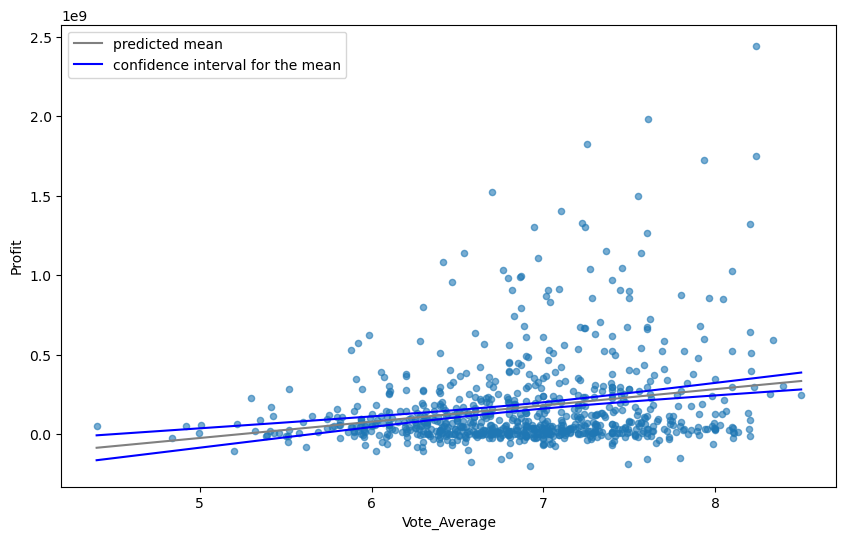

In [21]:
pred = lm_profit_va.get_prediction(x_pred).summary_frame()

movies_2015_2024.plot(
    kind = 'scatter',
    x = 'Vote_Average',
    y = 'Profit',
    alpha=0.6,
    figsize = (10,6)
)

plt.plot(x_pred['Vote_Average'], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred['Vote_Average'], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval for the mean')
plt.plot(x_pred['Vote_Average'], pred['mean_ci_upper'], color = 'blue')

plt.legend();

In [22]:
x_pred = pd.DataFrame({'Vote_Average': np.linspace(start = movies_2015_2024['Vote_Average'].min(),
                                    stop = movies_2015_2024['Vote_Average'].max(), num = 250)})

lm_profit_va.get_prediction(x_pred).summary_frame().head(2)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-8.658852e+07,3.990786e+07,-1.649246e+08,-8.252478e+06,-6.469511e+08,4.737741e+08
1,-8.490115e+07,3.965970e+07,-1.627501e+08,-7.052228e+06,-6.451959e+08,4.753936e+08


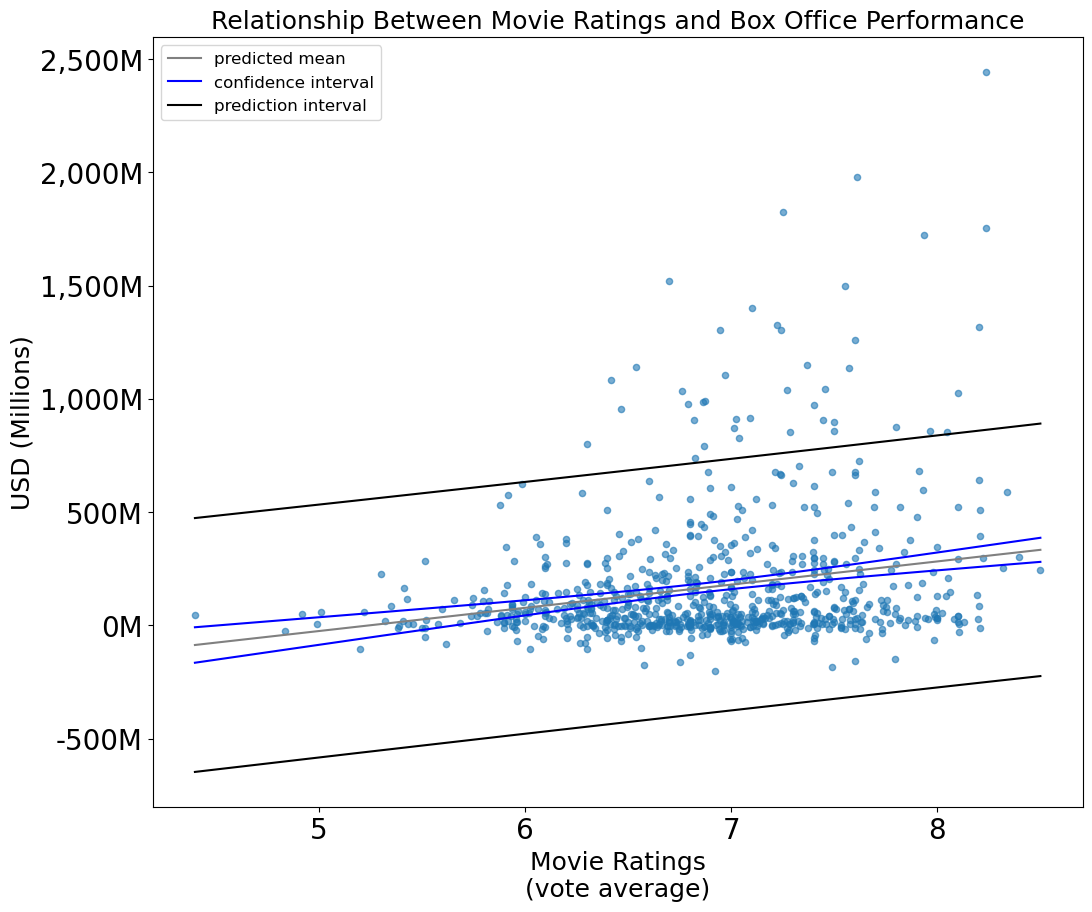

In [23]:
x_pred = pd.DataFrame({'Vote_Average': np.linspace(start = movies_2015_2024['Vote_Average'].min(),
                                    stop = movies_2015_2024['Vote_Average'].max(), num = 250)})

pred = lm_profit_va.get_prediction(x_pred).summary_frame()

fig, ax = plt.subplots(figsize=(15, 10))

movies_2015_2024.plot(
    ax=ax,
    kind = 'scatter',
    x = 'Vote_Average',
    y = 'Profit',
    alpha=0.6,
    figsize = (12,10)
)

plt.xticks(rotation=0, fontsize = 20);
ax.set_xlabel('Movie Ratings\n(vote average)', fontsize=18)

plt.yticks(fontsize = 20);
ax.set_ylabel('USD (Millions)', fontsize=18)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

plt.plot(x_pred['Vote_Average'], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred['Vote_Average'], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval')
plt.plot(x_pred['Vote_Average'], pred['mean_ci_upper'], color = 'blue')

plt.plot(x_pred['Vote_Average'], pred['obs_ci_lower'], color = 'black', label = 'prediction interval')
plt.plot(x_pred['Vote_Average'], pred['obs_ci_upper'], color = 'black')

plt.title('Relationship Between Movie Ratings and Box Office Performance', fontsize=18)


plt.legend(fontsize = 12)

#plt.savefig('../assets/voteavg_profit_scatter_prediction_mean.png', dpi = 150);

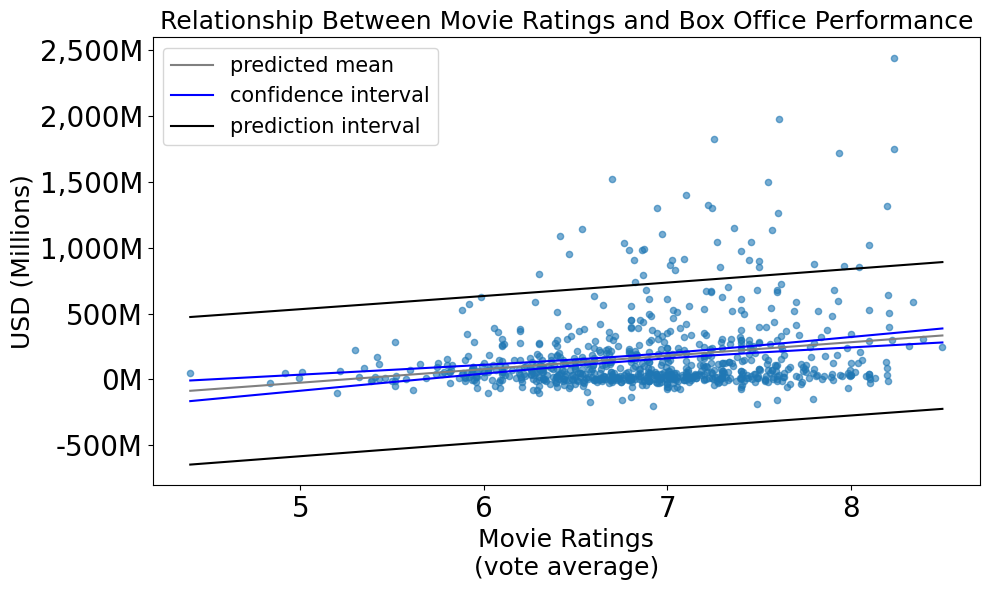

In [24]:
x_pred = pd.DataFrame({'Vote_Average': np.linspace(start = movies_2015_2024['Vote_Average'].min(),
                                    stop = movies_2015_2024['Vote_Average'].max(), num = 250)})

pred = lm_profit_va.get_prediction(x_pred).summary_frame()

fig, ax = plt.subplots(figsize=(15, 10))

movies_2015_2024.plot(
    ax=ax,
    kind = 'scatter',
    x = 'Vote_Average',
    y = 'Profit',
    alpha=0.6,
    figsize = (10,6)
)


plt.xticks(rotation=0, fontsize = 20);
ax.set_xlabel('Movie Ratings\n(vote average)', fontsize=18)

plt.yticks(fontsize = 20);
ax.set_ylabel('USD (Millions)', fontsize=18)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

plt.plot(x_pred['Vote_Average'], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred['Vote_Average'], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval')
plt.plot(x_pred['Vote_Average'], pred['mean_ci_upper'], color = 'blue')

plt.plot(x_pred['Vote_Average'], pred['obs_ci_lower'], color = 'black', label = 'prediction interval')
plt.plot(x_pred['Vote_Average'], pred['obs_ci_upper'], color = 'black')

plt.title('Relationship Between Movie Ratings and Box Office Performance', fontsize=18)

plt.legend(fontsize = 15)
plt.tight_layout()
#plt.savefig('../assets/voteavg_profit_scatter_prediction_mean.png', dpi = 150);

In [25]:
prof_lower_movies = movies_2015_2024[movies_2015_2024["Profit"] <=500000000]
df = prof_lower_movies[prof_lower_movies["Profit"] > 0]
df["Profit"].min()

60492

In [26]:
# We assume the average of our target variable, vote avg, is a linear function of the predictor variable, revenue 
lm_prof_va = smf.ols('Profit ~ Vote_Average', data = df).fit()
lm_prof_va.params

Intercept      -1.875906e+07
Vote_Average    1.997082e+07
dtype: float64

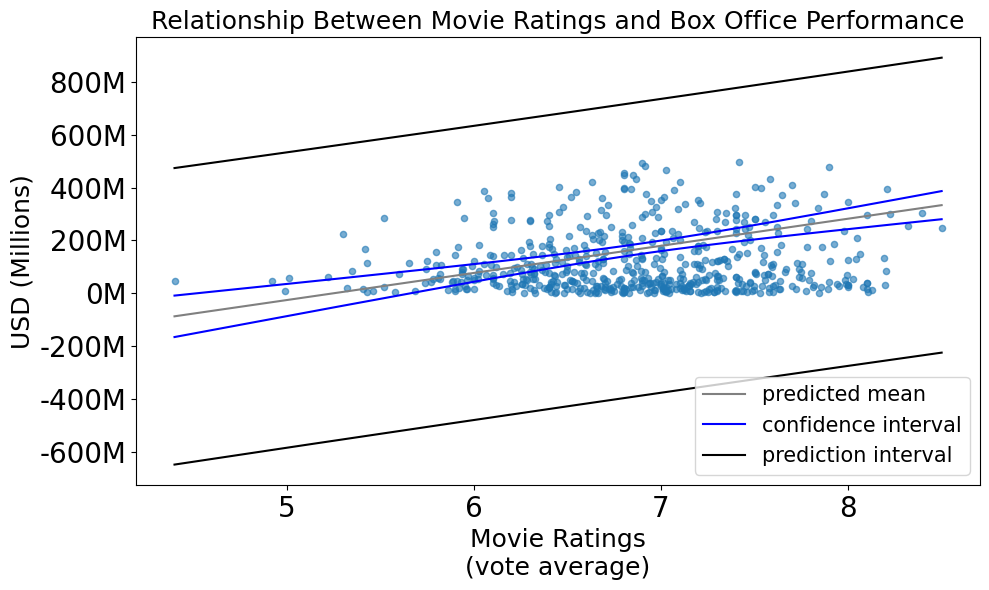

In [27]:
x_pred = pd.DataFrame({'Vote_Average': np.linspace(start = df['Vote_Average'].min(),
                                    stop = df['Vote_Average'].max(), num = 250)})

pred = lm_profit_va.get_prediction(x_pred).summary_frame()

fig, ax = plt.subplots(figsize=(15, 10))

df.plot(
    ax=ax,
    kind = 'scatter',
    x = 'Vote_Average',
    y = 'Profit',
    alpha=0.6,
    figsize = (10,6)
)

plt.xticks(rotation=0, fontsize = 20);
ax.set_xlabel('Movie Ratings\n(vote average)', fontsize=18)

plt.yticks(fontsize = 20);
ax.set_ylabel('USD (Millions)', fontsize=18)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

plt.plot(x_pred['Vote_Average'], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred['Vote_Average'], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval')
plt.plot(x_pred['Vote_Average'], pred['mean_ci_upper'], color = 'blue')

plt.plot(x_pred['Vote_Average'], pred['obs_ci_lower'], color = 'black', label = 'prediction interval')
plt.plot(x_pred['Vote_Average'], pred['obs_ci_upper'], color = 'black')

plt.title('Relationship Between Movie Ratings and Box Office Performance', fontsize=18)

plt.legend(fontsize = 15)
plt.tight_layout()
#plt.savefig('../assets/voteavg_profit_scatter_prediction_mean.png', dpi = 150);

In [28]:
# We assume the average of our target variable, vote avg, is a linear function of the predictor variable, profit 
lm_logprof_va = smf.ols('np.log(Profit+200000000) ~ Vote_Average', data = movies_2015_2024).fit()
lm_logprof_va.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(Profit + 200000000)   R-squared:                       0.036
Model:                                    OLS   Adj. R-squared:                  0.035
Method:                         Least Squares   F-statistic:                     30.33
Date:                        Tue, 25 Nov 2025   Prob (F-statistic):           4.90e-08
Time:                                21:20:15   Log-Likelihood:                -736.34
No. Observations:                         805   AIC:                             1477.
Df Residuals:                             803   BIC:                             1486.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       18.2658      0.230     79.350      0.000      17.814      18.718
Vote_Average     0.1834      0.033      5.507      0.000       0.118       0.249
==============================================================================
Omnibus:                      334.113   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10860.417
Skew:                          -1.222   Prob(JB):                         0.00
Kurtosis:                      20.827   Cond. No.                         76.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
np.exp(0.1834)

1.2012948299220259

In [30]:
pred.head(2)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-8.658852e+07,3.990786e+07,-1.649246e+08,-8.252478e+06,-6.469511e+08,4.737741e+08
1,-8.490115e+07,3.965970e+07,-1.627501e+08,-7.052228e+06,-6.451959e+08,4.753936e+08


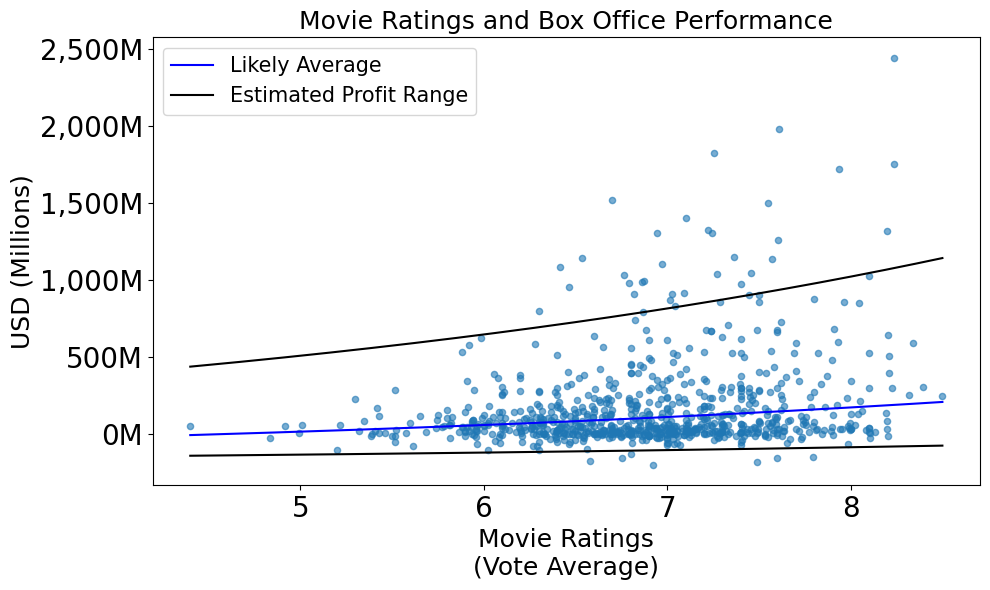

In [31]:
x_pred = pd.DataFrame({'Vote_Average': np.linspace(start = df['Vote_Average'].min(),
                                    stop = df['Vote_Average'].max(), num = 250)})

#pred = lm_logprof_va.get_prediction(x_pred).summary_frame()
pred = np.exp(lm_logprof_va.get_prediction(x_pred).summary_frame())-200000000

fig, ax = plt.subplots(figsize=(15, 10))

movies_2015_2024.plot(
    ax=ax,
    kind = 'scatter',
    x = 'Vote_Average',
    y = 'Profit',
    alpha=0.6,
    figsize = (10,6)
)

plt.xticks(rotation=0, fontsize = 20);
ax.set_xlabel('Movie Ratings\n(Vote Average)', fontsize=18)

plt.yticks(fontsize = 20);
ax.set_ylabel('USD (Millions)', fontsize=18)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

plt.plot(x_pred['Vote_Average'], pred['mean'], color = 'blue', label = 'Likely Average')

plt.plot(x_pred['Vote_Average'], pred['obs_ci_lower'], color = 'black', label = 'Estimated Profit Range')
plt.plot(x_pred['Vote_Average'], pred['obs_ci_upper'], color = 'black')

plt.title('Movie Ratings and Box Office Performance', fontsize=18)

plt.legend(fontsize = 15)
plt.tight_layout()
plt.savefig('../assets/voteavg_profit_scatter_prediction_mean.png', dpi = 150);